In [6]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify
from FKMC.general import shapes 
from FKMC.plotting import spread

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [2]:
from FKMC.general import interaction_matrix, solve_H_vectorised
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index,  compute_IPR_and_DOS_histograms, interpolate_IPR


energy_histogram_bins = E_bins = np.linspace(-4, 4, 2000 + 1)

N_states = int(1e3) # average over N_states // N replications
t = 1
U = 2
Ns = np.array([40,  60,  70,  80, 100, 120, 150, 180, 220, 270])
rng = np.random.default_rng()

Ts = [1.5, 2.5]
Us = [2, 5]
disorder_data = np.array([
    [ #U = 2 U_i = 0
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.8095890000000001, 0.7996353333333337, 0.8024489795918364, 0.7962247499999999, 0.8097218399999999, 0.7909586111111111, 0.8109371733333332, 0.8128113086419754, 0.8081882314049587, 0.8092678847736622])
        ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.17062400000000005, 0.1217746666666667, 0.1011862857142857, 0.103533625, 0.08152208000000001, 0.06948605555555555, 0.06154023111111111, 0.05436165432098765, 0.045623024793388436, 0.040707226337448554]),
        ),
    ],
    [#U = 5 U_i = 1
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.8140095, 0.8023942222222225, 0.807825959183673, 0.8145024999999999, 0.81666472, 0.817028611111111, 0.8053220977777776, 0.8104926666666665, 0.8188372727272728, 0.8083993415637856])
    ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.15642450000000002, 0.12025133333333335, 0.1100285714285714, 0.104929125, 0.08670792000000001, 0.07406583333333333, 0.06431651555555554, 0.056547012345679014, 0.04651963636363636, 0.04189197256515774])
        ),
    ],
])


for U_i, U in enumerate(Us):
    for T_i, T in enumerate(Ts):
        o = disorder_data[U_i, T_i]
        o.parameters.m2s = np.array(o.parameters.m2s)
        o.parameters.defect_densities = 1 - np.sqrt(o.parameters.m2s)
        o.Mf_moments = o.parameters.m2s[:, None, None] * np.ones(6)[None, None, :]
        o.parameters.update(mu=0.0, t = t, alpha = 1.25, J = 1.0)
        
        o.DOS, o.dDOS, o.IPR, o.dIPR = np.empty((4, len(Ns), 2000))
        for N_i, N in enumerate(Ns):
            M = N_states
            defect_density = o.parameters.defect_densities[N_i]
            CDW = (np.arange(N)%2)[None, :]
            disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
            defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
            states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density
            
            scale = 0.5
            
            o.parameters.N = N
            o.parameters.J_matrix = interaction_matrix(**o.parameters)
             

            #NB the states argument should have only 1s and 0s
            #Fc is infinite at infinite temperature
            Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)

            #calculate the IPR measure
            raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

            DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, energy_histogram_bins, bootstrap_bins = 1)

            interpolate_IPR(energy_histogram_bins, unsmoothed_DOS=DOS, IPR=IPR, dIPR=dIPR)

            #smooth out the spikey IPR values
            o.DOS[N_i] = smooth(DOS, scale = scale, axis = -1)
            o.IPR[N_i] = smooth(IPR, scale = scale, axis = -1)

            o.dDOS[N_i] = smooth(dDOS, scale = scale, axis = -1)
            o.dIPR[N_i] = smooth(dIPR, scale = scale, axis = -1)

            o.parameters.J_matrix = None

In [3]:
p = Path('~/HPC_data/pickled_data/disorder_data_individual.pickle').expanduser()
with open(p, 'wb') as f:
    pickle.dump(disorder_data, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful') 

Pickling Successful


In [68]:
from FKMC.general import interaction_matrix, solve_H_vectorised
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index,  compute_IPR_and_DOS_histograms, interpolate_IPR


energy_histogram_bins = E_bins = np.linspace(-4, 4, 2000 + 1)

N_states = int(1e4) # average over N_states // N replications
t = 1
U = 2
Ns = np.array([40,  60,  70,  80, 100, 120, 150, 180, 220, 270])
# Ns = np.concatenate([Ns, np.logspace(np.log10(400), np.log10(5000), 7, dtype = int) // 10 * 10])
rng = np.random.default_rng()

Ts = [1.5, 2.5]
Us = [2, 5]
disorder_data = np.array([
    [ #U = 2 U_i = 0
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.8095890000000001, 0.7996353333333337, 0.8024489795918364, 0.7962247499999999, 0.8097218399999999, 0.7909586111111111, 0.8109371733333332, 0.8128113086419754, 0.8081882314049587, 0.8092678847736622])
        ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.17062400000000005, 0.1217746666666667, 0.1011862857142857, 0.103533625, 0.08152208000000001, 0.06948605555555555, 0.06154023111111111, 0.05436165432098765, 0.045623024793388436, 0.040707226337448554]),
        ),
    ],
    [#U = 5 U_i = 1
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.8140095, 0.8023942222222225, 0.807825959183673, 0.8145024999999999, 0.81666472, 0.817028611111111, 0.8053220977777776, 0.8104926666666665, 0.8188372727272728, 0.8083993415637856])
    ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.15642450000000002, 0.12025133333333335, 0.1100285714285714, 0.104929125, 0.08670792000000001, 0.07406583333333333, 0.06431651555555554, 0.056547012345679014, 0.04651963636363636, 0.04189197256515774])
        ),
    ],
])


for U_i, U in enumerate(Us):
    for T_i, T in enumerate(Ts):
        o = disorder_data[U_i, T_i]
        o.parameters.m2s = np.array(o.parameters.m2s)
        o.parameters.defect_densities = 1 - np.sqrt(o.parameters.m2s)
        o.Mf_moments = o.parameters.m2s[:, None, None] * np.ones(6)[None, None, :]
        o.parameters.update(mu=0.0, t = t, alpha = 1.25, J = 1.0)
        
        defect_density = o.parameters.defect_densities[-1]
        o.DOS, o.dDOS, o.IPR, o.dIPR = np.empty((4, len(Ns), 2000))
        for N_i, N in enumerate(Ns):
            M = max(N_states // N, 5)
            
            CDW = (np.arange(N)%2)[None, :]
            disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
            defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
            states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density
            
            scale = 0.5
            
            o.parameters.N = N
            o.parameters.J_matrix = interaction_matrix(**o.parameters)
             

            #NB the states argument should have only 1s and 0s
            #Fc is infinite at infinite temperature
            Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)

            #calculate the IPR measure
            raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

            DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, energy_histogram_bins, bootstrap_bins = 1)

            interpolate_IPR(energy_histogram_bins, unsmoothed_DOS=DOS, IPR=IPR, dIPR=dIPR)

            #smooth out the spikey IPR values
            o.DOS[N_i] = smooth(DOS, scale = scale, axis = -1)
            o.IPR[N_i] = smooth(IPR, scale = scale, axis = -1)

            o.dDOS[N_i] = smooth(dDOS, scale = scale, axis = -1)
            o.dIPR[N_i] = smooth(dIPR, scale = scale, axis = -1)

            o.parameters.J_matrix = None
            
p = Path('~/HPC_data/pickled_data/disorder_data_individual_fixed_density.pickle').expanduser()
with open(p, 'wb') as f:
    pickle.dump(disorder_data, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful')

Pickling Successful


In [69]:
p = Path('~/HPC_data/pickled_data/disorder_data_individual.pickle').expanduser()
with open(p, 'rb') as f:
    disorder_data = pickle.load(f)
    print('UnPickling Successful') 
    
p = Path('~/HPC_data/pickled_data/disorder_data_individual_fixed_density.pickle').expanduser()
with open(p, 'rb') as f:
    disorder_data_fixed = pickle.load(f)
    print('UnPickling Successful') 

UnPickling Successful
UnPickling Successful



Anderson Phase
disorder \omega_0 = 0.058
disorder \tau_0 = 0.13\pm0.01
disorder \omega_1 = 0.810
disorder \tau_1 = 0.00\pm0.01
disorder \omega_0 = 0.058
disorder \tau_0 = 0.02\pm0.04
disorder \omega_1 = 0.810
disorder \tau_1 = 0.06\pm0.03

U = 2 T = 2.5
m^2 = [0.17062400000000005, 0.1217746666666667, 0.1011862857142857, 0.103533625, 0.08152208000000001, 0.06948605555555555, 0.06154023111111111, 0.05436165432098765, 0.045623024793388436, 0.040707226337448554]
\omega_0 = 0.057
\tau_0 = 0.06\pm0.01
\omega_1 = 0.810
\tau_1 = 0.02\pm0.01

CDW Phase
disorder \omega_0 = 0.058
disorder \tau_0 = 0.07\pm0.01
disorder \omega_1 = 0.810
disorder \tau_1 = 0.33\pm0.01
disorder \omega_0 = 0.058
disorder \tau_0 = 0.05\pm0.03
disorder \omega_1 = 0.810
disorder \tau_1 = 0.30\pm0.05

U = 2 T = 1.5
m^2 = [0.8095890000000001, 0.7996353333333337, 0.8024489795918364, 0.7962247499999999, 0.8097218399999999, 0.7909586111111111, 0.8109371733333332, 0.8128113086419754, 0.8081882314049587, 0.8092678847736622]
\om

/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


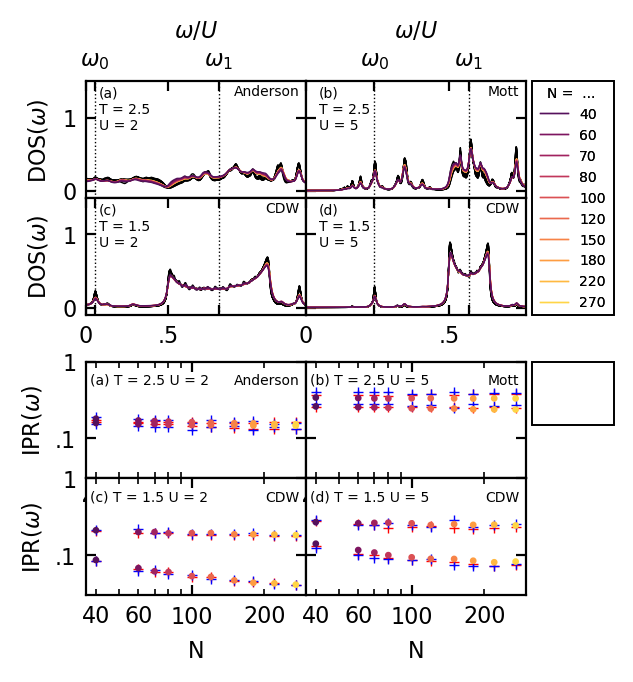

In [70]:
columnwidth = 246/72.27
plt.style.use('../custom.mplstyle')
from customcolors import colors, colors10, custom_cmap

DOSxlim = np.array([0, 1.2])
DOSylim = (-0.1,1.5)

IPRylim = (0.03, 0.3)
Es = [
    lambda o: 1/16 * 0.9 if o.parameters.U == 2 else 1/4 * 0.96,
    lambda o: 1/4 * (1 + np.sqrt(1 + 16/o.parameters.U**2)),
     ]

linewidth = 0.5
legend_fontsize = 5
legend_wspace = 0.01
legend_labelspacing = 0.5
wspace = 0
hspace = 0

with open(Path('~/HPC_data/pickled_data/individual_IPRs.pickle').expanduser(), 'rb') as file:
    os = pickle.load(file)

from FKMC.general import get_nearby_index
from customcolors import colors, colors10

def pulloutbytemp_and_U(o, T_i, U_i):
    newo = o.copy()
    newo.DOS = newo.DOS[:, U_i, T_i]
    newo.IPR = newo.IPR[:, U_i, T_i]
    newo.dDOS = newo.dDOS[:, U_i, T_i]
    newo.dIPR = newo.dIPR[:, U_i, T_i]
    newo.Mf_moments = newo.Mf_moments[:, :, U_i, T_i, :]
    newo.parameters.beta = 1 / o.Ts[T_i]
    newo.parameters.U = o.Us[U_i]
    return newo


o_disorder = disorder_data[T_i, U_i]


def plot_DOS(ax, o, letter, linecolors = colors10):
    DOS = np.where(o.DOS > 0.001, o.DOS, np.NaN)
    lines = [None for _ in o.Ns]
    for i, N in list(enumerate(o.Ns))[::-1]:
        lines[i], = ax.plot(o.E_bins[1:] / o.parameters.U, DOS[i], label = f'N = {N}', color = linecolors[i], linewidth = linewidth) 
        
    xlim = 1/2 * np.sqrt(1 + 16/o.parameters.U**2) * DOSxlim
    ax.set(xlim = xlim, ylim = DOSylim)
    
    #do the arrows showing where the IPRs are taken
    for e in Es: 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        x, y = (true_E, max(o.DOS[:, E_i]))
        ax.vlines(x, ax.get_ylim()[0], ax.get_ylim()[1], colors='k', linestyles='dotted', linewidth = linewidth)

    label = "\n".join([
             f"({letter})",
             f"T = {1 / o.parameters.beta}",
             f"U = {o.parameters.U}",
             ])
    ax.text(0.06, 0.96, label, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', color = 'black')
    
    return lines

def plot_IPR_scaling(ax, o, letter):
    lines = [None for _ in Es]
    print(f'\nU = {o.parameters.U} T = {1/o.parameters.beta}')
    print(f'm^2 = {list(o.Mf_moments[:, :, 2].mean(axis = 1))}')
    for i, e, linestyle in zip(count(), Es, ['dashed', 'dotted']): 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        print(f'\omega_{i} = {true_E:.3f}')
        IvN = np.array([o.IPR[i, E_i] for i, _ in enumerate(o.Ns)])
        dIvN = np.array([o.dIPR[i, E_i] for i, _ in enumerate(o.Ns)])

        #model is IPR(N) = A * N ^ (-tau)
        def IPR(N, A, tau): return A * N ** (-tau)
        idx = o.Ns > 70
        (A, tau), pcov = scipy.optimize.curve_fit(IPR, o.Ns[idx], IvN[idx], p0=(0.5, 0.5), sigma=dIvN[idx], absolute_sigma=True)
        dA, dtau = np.sqrt(np.diag(pcov))
        
        #lines[i], = ax.plot(o.Ns, IPR(o.Ns, A, tau), linestyle = linestyle, color = 'k', marker = None, linewidth = linewidth*2)
        #ax.errorbar(o.Ns, IvN, yerr = dIvN, fmt = 'none', ecolor = 'k',
        #            elinewidth = linewidth / 2, capsize = 1, capthick = linewidth / 2)
        ax.scatter(o.Ns, IvN, c = colors10, s = 2, zorder = 3)
        
        def errorfmt(a, da):
            digit = -int(np.floor(np.log10(da)))
            d = f'{da:.1g}'[-1]
            return f'{a:.{digit}f}({d})'
        
        print(f'\\tau_{i} = {tau:.2f}\pm{dtau:.2f}')
        
        
        ax.set(
               yscale = 'log', 
               xscale = 'log',
               ylim = IPRylim,
              )
        
    label = " ".join([
             f"({letter})",
             f"T = {1 / o.parameters.beta}",
             f"U = {o.parameters.U}",
             ])
    ax.text(0.02, 0.9, label, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', color = 'black')
    return lines

def plot_IPR_scaling_disorder(ax, o, letter, color):
    lines = [None for _ in Es]
    for i, e, linestyle in zip(count(), Es, ['dashed', 'dotted']): 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        print(f'disorder \omega_{i} = {true_E:.3f}')
        IvN = np.array([o.IPR[i, E_i] for i, _ in enumerate(o.Ns)])
        dIvN = np.array([o.dIPR[i, E_i] for i, _ in enumerate(o.Ns)])

        #model is IPR(N) = A * N ^ (-tau)
        def IPR(N, A, tau): return A * N ** (-tau)
        idx = o.Ns > 70
        (A, tau), pcov = scipy.optimize.curve_fit(IPR, o.Ns[idx], IvN[idx], p0=(0.5, 0.5),
                                                  sigma=dIvN[idx], absolute_sigma=True)
        dA, dtau = np.sqrt(np.diag(pcov))
        
        #lines[i], = ax.plot(o.Ns, IPR(o.Ns, A, tau), linestyle = linestyle, color = 'k', 
        #                    marker = 'x', markersize = 3, linewidth = linewidth*2)
        #ax.errorbar(o.Ns, IvN, yerr = dIvN, fmt = 'none', ecolor = 'k',
        #            elinewidth = linewidth / 2, capsize = 1, capthick = linewidth / 2)
        ax.scatter(o.Ns, IvN, c = color, zorder = -10, marker = '+', s = 15, linewidth = 0.5)
        
        def errorfmt(a, da):
            digit = -int(np.floor(np.log10(da)))
            d = f'{da:.1g}'[-1]
            return f'{a:.{digit}f}({d})'
        
        print(f'disorder \\tau_{i} = {tau:.2f}\pm{dtau:.2f}')

f = plt.figure(constrained_layout=False)

#make a split between the top and bottom
gs = f.add_gridspec(ncols = 1, nrows = 2, hspace = 0.2)
groups = [None, None]
legend_axes = [None, None]

for i in range(2):
    sgs = gs[i].subgridspec(nrows = 2, ncols = 3, 
                                      width_ratios=[1, 1, 0.4],
                                      hspace = 0,
                                      wspace = 0,
                                     )
    groups[i] = np.array([
                 [f.add_subplot(sgs[0, 0]), f.add_subplot(sgs[1, 0])],
                 [f.add_subplot(sgs[0, 1]), f.add_subplot(sgs[1, 1])],
                ])
           
    legend_axes[i] = f.add_subplot(sgs[:, 2], visible = False)


for U_i, col, labels in zip(count(), groups[0], [['a','c'], ['b','d']]):
    for T_i, ax, label in zip([1,0], col, labels):
        
        od = disorder_data[U_i, T_i]
        for i, N in list(enumerate(od.Ns))[::-1]:
            ax.plot(od.E_bins[1:] / od.parameters.U, od.DOS[i], label = f'N = {N}', color = 'k', linewidth = linewidth) 
        
        o = pulloutbytemp_and_U(os, T_i = T_i, U_i = U_i)
        lines = plot_DOS(ax, o, label)

        
        ax.set(xticks = [0, 0.5] + [e(o) for e in Es],)
        
        if T_i == 1: #set the omega labels for the top of the DOS plot
            ax.tick_params(bottom = False, labelbottom = False, top = True, labeltop = True)
            ax.set(xticklabels = ['', ''] + [f'$\omega_{i}$' for i, _ in enumerate(Es)],
                  xlabel = '$\omega / U$',
                  )
            ax.xaxis.set_label_position('top')
            
        if T_i == 0: #set the numerical xlabels for the bottom of the DOS plot
            ax.tick_params(top = True, labeltop = False, labelbottom = True)
            ax.set(
            xticklabels = ['0', '.5'] + ['', '']
            )
            
        if U_i == 0: ax.set(ylabel = 'DOS($\omega$)')
            
        phase = 'CDW' if T_i == 0 else ('Anderson' if U_i == 0 else 'Mott')
        ax.text(0.97, 0.97, phase, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', ha='right', color = 'black')
        
        

for U_i, col, labels in zip(count(), groups[1], [['a','c'], ['b','d']]):
    for T_i, ax, label in zip([1,0], col, labels):
        phase = 'CDW' if T_i == 0 else ('Anderson' if U_i == 0 else 'Mott')
        print(f"\n{phase} Phase")
        
        od = disorder_data[U_i, T_i]
        plot_IPR_scaling_disorder(ax, od, label, color = 'red')
        
        od = disorder_data_fixed[U_i, T_i]
        plot_IPR_scaling_disorder(ax, od, label, color = 'blue')
        
        o = pulloutbytemp_and_U(os, T_i = T_i, U_i = U_i)
        omega_lines = plot_IPR_scaling(ax, o, label)
        
        ax.set(yticks = [0.1, 1])
        
        if U_i == 0: ax.set(ylabel = 'IPR($\omega$)')
        if T_i == 0: ax.set(xlabel = 'N')
        if T_i == 1: 
            ax.tick_params(bottom = False, labelbottom = False)
            
        from matplotlib.ticker import StrMethodFormatter, NullFormatter, FixedFormatter, FixedLocator
        ax.yaxis.set_major_locator(FixedLocator([0.1, 1]))
        ax.yaxis.set_major_formatter(FixedFormatter(['.1', '1']) if U_i == 0 else NullFormatter())
        #ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}') if U_i == 0 else NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        
        ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
        #ax.xaxis.set_minor_formatter(StrMethodFormatter('{x:.0f}'))
        
        import matplotlib.ticker as ticker
        ax.xaxis.set_minor_formatter(ticker.FuncFormatter(
            lambda x,pos: f"{x:.0f}" if x in [40.0, 60.0, 200.0] else ''
        ))

        ax.text(0.97, 0.90, phase, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', ha='right', color = 'black')

#turn off the yticks labels for the right column
for g in groups: 
    for a in g[1, :]:
        a.tick_params(axis = 'y', labelleft = False)
        
#turn off the x ticks labels for the upper rows:
for g in groups: 
    for a in g[:, 0]:
        a.tick_params(axis = 'x', labelbottom = False)

    

    
def add_side_legend(axes, legend_axis, lines, labels, loc = 'center', rect_redefine = None):
    from matplotlib.legend import Legend
    #get the x position of the right of the plots in figure coords
    _, (x0, _) = axes[1,0].get_position().get_points()
    #get the y position of the bottom of the plots in figure coords
    (_, y0), _ = axes[1,1].get_position().get_points()
    #get the top right of the legend axis
    _, (x1, y1) = legend_axis.get_position().get_points()
    
    if rect_redefine: x0, y0, x1, y1 = rect_redefine(x0, y0, x1, y1)

    rect = mpl.patches.Rectangle((x0+legend_wspace,y0),x1-x0-legend_wspace,y1-y0,
                                 linewidth=0.7,
                                 edgecolor='k',
                                 facecolor='none',
                                 transform = f.transFigure)
    f.add_artist(rect)
    
    leg = f.legend(
                 handles = lines, 
                 labels = labels,
                 frameon=True,
                 fontsize = legend_fontsize,
                 loc = loc,
                 bbox_to_anchor=rect.get_bbox(),
                labelspacing = legend_labelspacing,
               fancybox = False,
               bbox_transform=f.transFigure,
    )
    #modify the frame of the legend
    frame = leg.get_frame()
    frame.set(visible = False)
    
    f.add_artist(leg);
    return leg, rect
    
leg, rect = add_side_legend(axes = groups[0], legend_axis = legend_axes[0], lines=lines, 
                      labels = [f"{N}" for N in o.Ns])
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

leg, rect = add_side_legend(axes = groups[1], legend_axis = legend_axes[1], lines=omega_lines, loc = 'upper center', 
                    rect_redefine = lambda x0, y0, x1, y1: (x0, y1 - (y1-y0)*0.27, x1, y1),
                    labels = [f"$\omega_{i}$" for i,e in enumerate(Es)])

f.subplots_adjust()
f.set_size_inches(columnwidth, columnwidth)
#f.savefig(figure_location / 'indiv_IPR.eps', bbox_inches='tight');

## Old version of this figure before I fixed the mapping between defect density and mˆ2

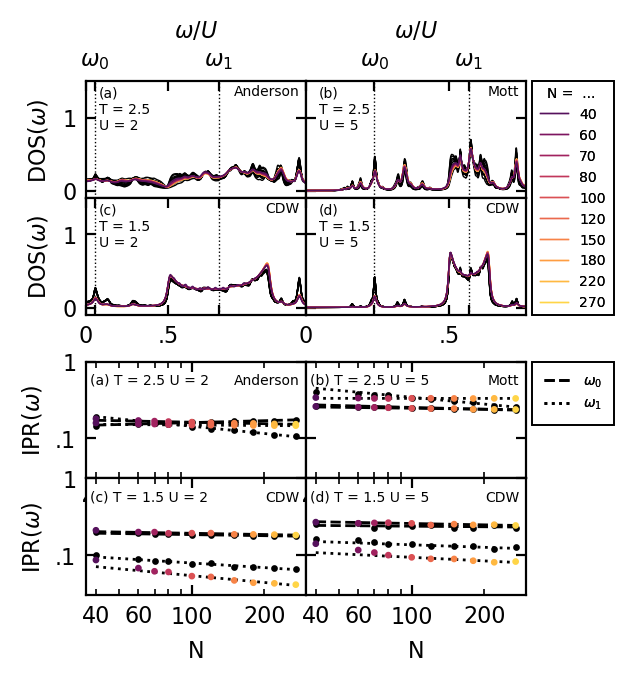

## After fixing that factor of two the curves now completely coincide
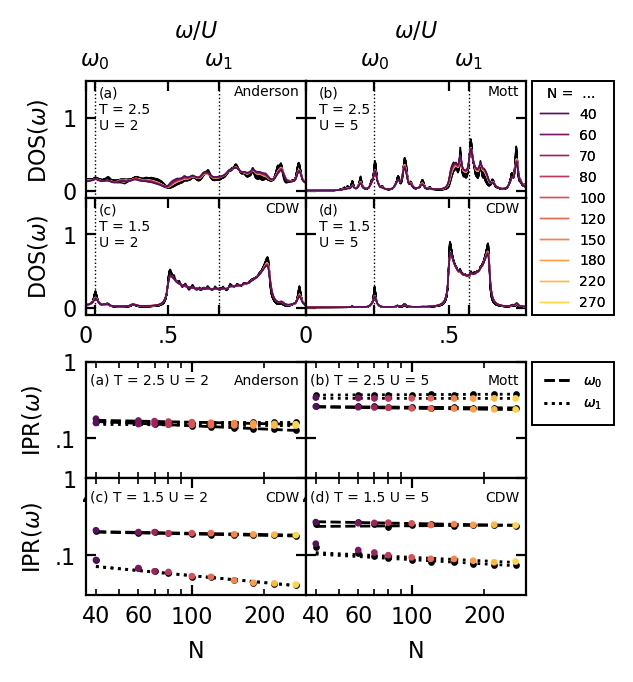

# But in the above, the defect density changes with system size 

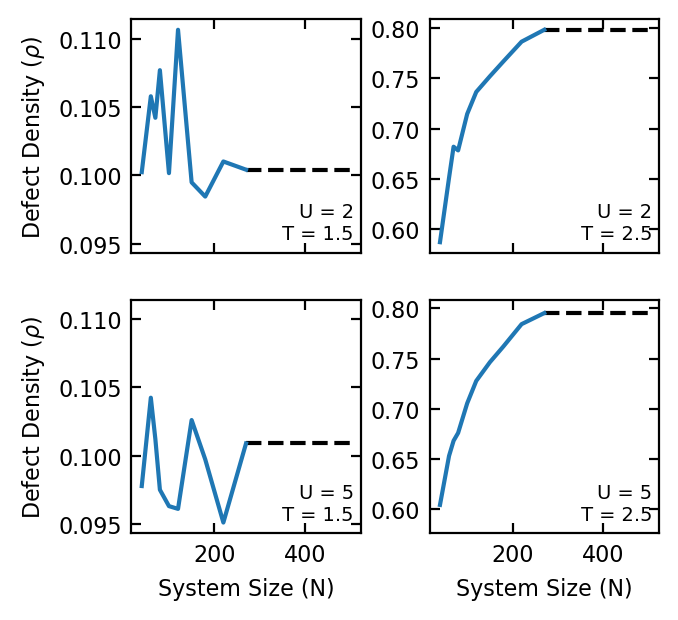

In [38]:
f, axes = plt.subplots(nrows = 2, ncols = 2, sharex = 'all', sharey = 'col', gridspec_kw = dict(wspace = 0.3))

for U_i in [0,1]:
    for T_i in [0,1]:
        o = disorder_data[U_i, T_i]
        o.parameters.m2s = np.array(o.parameters.m2s)
        o.parameters.defect_densities = 1 - np.sqrt(o.parameters.m2s)
        
        ax = axes[U_i,T_i]
        ax.plot(o.Ns, o.parameters.defect_densities)
        phase = f'U = {o.parameters.U}\n T = {Ts[T_i]}'
        ax.text(0.97, 0.04, phase, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='bottom', ha='right', color = 'black')
        
        ax.hlines(xmin = o.Ns[-1], xmax = 500, y = [o.parameters.defect_densities[-1],], linestyle = 'dashed')
        
        ax.set(xlabel = r"System Size (N)" if U_i else "",
              ylabel = r"Defect Density ($\rho$)" if not T_i else "")

# Same as the above but use the mean m squared and go to larger system sizes

In [78]:
from FKMC.general import interaction_matrix, solve_H_vectorised
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index,  compute_IPR_and_DOS_histograms, interpolate_IPR

energy_histogram_bins = E_bins = np.linspace(-4, 4, 2000 + 1)

N_states = int(1e4) # average over N_states // N replications
t = 1
U = 2
Ns = np.logspace(np.log10(60), np.log10(6e3), 10, dtype = int) // 10 * 10

Ns = np.array([40,  60,  70,  80, 100, 120, 150, 180, 220, 270])
Ns = np.concatenate([Ns, np.logspace(np.log10(290), np.log10(6000), 7, dtype = int) // 10 * 10])

rng = np.random.default_rng()
print(f'Ns = {Ns}')

Ts = [1.5, 2.5]
Us = [2, 5]
#the Ns that correspond to m2s from the FK model
#used for interpolation
original_Ns = np.array([40,  60,  70,  80, 100, 120, 150, 180, 220, 270]) 
disorder_data_bigger = np.array([
    [ #U = 2 U_i = 0
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.8095890000000001, 0.7996353333333337, 0.8024489795918364, 0.7962247499999999, 0.8097218399999999, 0.7909586111111111, 0.8109371733333332, 0.8128113086419754, 0.8081882314049587, 0.8092678847736622])
        ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.17062400000000005, 0.1217746666666667, 0.1011862857142857, 0.103533625, 0.08152208000000001, 0.06948605555555555, 0.06154023111111111, 0.05436165432098765, 0.045623024793388436, 0.040707226337448554]),
        ),
    ],
    [#U = 5 U_i = 1
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.8140095, 0.8023942222222225, 0.807825959183673, 0.8145024999999999, 0.81666472, 0.817028611111111, 0.8053220977777776, 0.8104926666666665, 0.8188372727272728, 0.8083993415637856])
    ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.15642450000000002, 0.12025133333333335, 0.1100285714285714, 0.104929125, 0.08670792000000001, 0.07406583333333333, 0.06431651555555554, 0.056547012345679014, 0.04651963636363636, 0.04189197256515774])
        ),
    ],
])

def process(U_i, T_i, o):
    print(f"U_i = {U_i}, T_i = {T_i} started\n")
    o.parameters.m2s = np.array(o.parameters.m2s)
    o.parameters.defect_densities = 1 - np.sqrt(o.parameters.m2s)
    o.Mf_moments = o.parameters.m2s[:, None, None] * np.ones(6)[None, None, :]
    o.parameters.update(mu=0.0, t = t, alpha = 1.25, J = 1.0)

    #in contrast to the above, use the mean defect density
    defect_density = o.parameters.defect_densities[-1]
    

    o.DOS, o.dDOS, o.IPR, o.dIPR = np.empty((4, len(Ns), 2000))
    for N_i, N in enumerate(Ns):
        t0 = time()
        M = max(N_states // N, 5)
        defect_density = np.interp(N, 
                                      xp = original_Ns,
                                      fp = o.parameters.defect_densities,
                                      left=o.parameters.defect_densities[0], 
                                      right=o.parameters.defect_densities[-1])

        CDW = (np.arange(N)%2)[None, :]
        disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
        defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
        states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density

        scale = 0.5

        o.parameters.N = N
        o.parameters.J_matrix = interaction_matrix(**o.parameters)


        #NB the states argument should have only 1s and 0s
        #Fc is infinite at infinite temperature
        Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)

        #calculate the IPR measure
        raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

        DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, energy_histogram_bins, bootstrap_bins = 1)

        interpolate_IPR(energy_histogram_bins, unsmoothed_DOS=DOS, IPR=IPR, dIPR=dIPR)

        #smooth out the spikey IPR values
        o.DOS[N_i] = smooth(DOS, scale = scale, axis = -1)
        o.IPR[N_i] = smooth(IPR, scale = scale, axis = -1)

        o.dDOS[N_i] = smooth(dDOS, scale = scale, axis = -1)
        o.dIPR[N_i] = smooth(dIPR, scale = scale, axis = -1)

        o.parameters.J_matrix = None
        print(f'Did U_i = {U_i}, T_i = {T_i}, N = {N} in {time() - t0:.0f} seconds')
    return o

import multiprocessing as mp
with mp.Pool(4) as pool:
    for U_i, U in enumerate(Us):
        for T_i, T in enumerate(Ts):
            disorder_data_bigger[U_i, T_i] = pool.apply_async(process, (U_i, T_i, disorder_data_bigger[U_i, T_i]))

    print('closing')
    pool.close()
#     print('joining')
#     pool.join()
    
    print('getting results')
    for U_i, U in enumerate(Us):
        for T_i, T in enumerate(Ts):
            disorder_data_bigger[U_i, T_i] = disorder_data_bigger[U_i, T_i].get(timeout = 15*60)
        
print('done!')

p = Path('~/HPC_data/pickled_data/disorder_data_individual_larger_2.pickle').expanduser()
with open(p, 'wb') as f:
    pickle.dump(disorder_data_bigger, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful') 

Ns = [  40   60   70   80  100  120  150  180  220  270  290  480  790 1310
 2180 3620 5990]
U_i = 0, T_i = 1 started
U_i = 0, T_i = 0 started
U_i = 1, T_i = 0 started
U_i = 1, T_i = 1 started




closing
getting results
Did U_i = 0, T_i = 1, N = 40 in 0 secondsDid U_i = 1, T_i = 1, N = 40 in 0 secondsDid U_i = 0, T_i = 0, N = 40 in 0 seconds


Did U_i = 1, T_i = 0, N = 40 in 0 seconds
Did U_i = 0, T_i = 0, N = 60 in 0 secondsDid U_i = 1, T_i = 1, N = 60 in 0 seconds

Did U_i = 0, T_i = 1, N = 60 in 0 seconds
Did U_i = 1, T_i = 0, N = 60 in 0 seconds
Did U_i = 1, T_i = 1, N = 70 in 0 secondsDid U_i = 0, T_i = 1, N = 70 in 0 seconds

Did U_i = 0, T_i = 0, N = 70 in 0 seconds
Did U_i = 1, T_i = 0, N = 70 in 0 seconds
Did U_i = 1, T_i = 1, N = 80 in 0 seconds
Did U_i = 0, T_i = 1, N = 80 in 0 seconds
Did U_i = 0, T_i = 0, N = 80 in 0 seconds
Did U_i = 1, T_i = 0, N = 80 in 0 seconds
Did U_i = 1, T_i = 1, N = 100 in 0 seconds
Did U_i = 0, T_i = 1, N = 100 in 0 seconds
Did U_i = 0, T_i = 0,

UnPickling Successful
UnPickling Successful

Anderson Phase
disorder \omega_0 = 0.058
disorder \tau_0 = 0.02\pm0.05
disorder \omega_1 = 0.810
disorder \tau_1 = 0.01\pm0.05
disorder \omega_0 = 0.058
disorder \tau_0 = 0.21\pm0.41
disorder \omega_1 = 0.810
disorder \tau_1 = -0.12\pm0.38

U = 2 T = 2.5
m^2 = [0.17062400000000005, 0.1217746666666667, 0.1011862857142857, 0.103533625, 0.08152208000000001, 0.06948605555555555, 0.06154023111111111, 0.05436165432098765, 0.045623024793388436, 0.040707226337448554]
\omega_0 = 0.057
\tau_0 = 0.06\pm0.01
\omega_1 = 0.810
\tau_1 = 0.02\pm0.01

CDW Phase
disorder \omega_0 = 0.058
disorder \tau_0 = 0.04\pm0.05
disorder \omega_1 = 0.810
disorder \tau_1 = 0.07\pm0.05
disorder \omega_0 = 0.058
disorder \tau_0 = -0.12\pm0.29
disorder \omega_1 = 0.810
disorder \tau_1 = 0.17\pm0.54

U = 2 T = 1.5
m^2 = [0.8095890000000001, 0.7996353333333337, 0.8024489795918364, 0.7962247499999999, 0.8097218399999999, 0.7909586111111111, 0.8109371733333332, 0.812811308641975

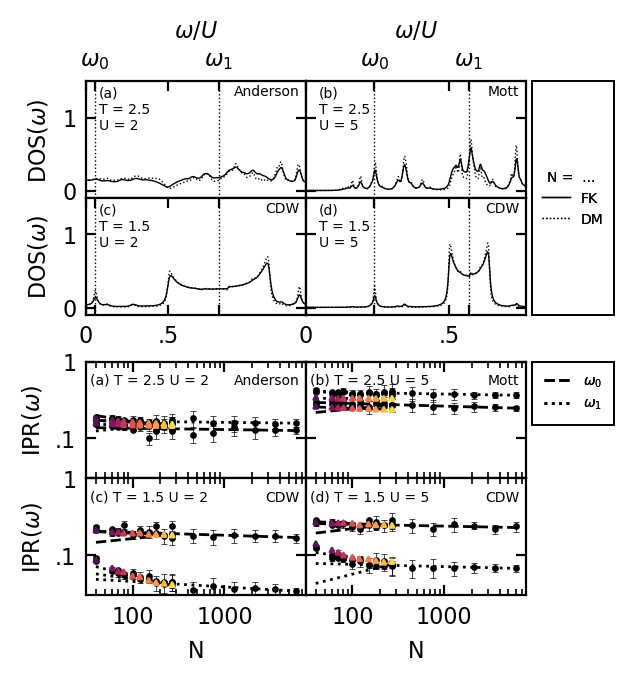

In [74]:
#code to generate the data for this figure is in short_paper_figure_code/uncorr_disorder_model_IPR_scaling-Copy1.ipynb
columnwidth = 246/72.27
plt.style.use('../custom.mplstyle')
from customcolors import colors, colors10, custom_cmap

DOSxlim = np.array([0, 1.2])
DOSylim = (-0.1,1.5)

IPRylim = (0.03, 0.3)
Es = [
    lambda o: 1/16 * 0.9 if o.parameters.U == 2 else 1/4 * 0.96,
    lambda o: 1/4 * (1 + np.sqrt(1 + 16/o.parameters.U**2)),
     ]

linewidth = 0.5
legend_fontsize = 5
legend_wspace = 0.01
legend_labelspacing = 0.5
wspace = 0
hspace = 0

with open(Path('~/HPC_data/pickled_data/individual_IPRs.pickle').expanduser(), 'rb') as file:
    os = pickle.load(file)
    
p = Path('~/HPC_data/pickled_data/disorder_data_individual_larger_2.pickle').expanduser()
with open(p, 'rb') as f:
    disorder_data_bigger = pickle.load(f)
    print('UnPickling Successful') 

p = Path('~/HPC_data/pickled_data/disorder_data_individual_fixed_density.pickle').expanduser()
with open(p, 'rb') as f:
    disorder_data_fixed = pickle.load(f)
    print('UnPickling Successful') 


from FKMC.general import get_nearby_index
from customcolors import colors, colors10

def pulloutbytemp_and_U(o, T_i, U_i):
    newo = o.copy()
    newo.DOS = newo.DOS[:, U_i, T_i]
    newo.IPR = newo.IPR[:, U_i, T_i]
    newo.dDOS = newo.dDOS[:, U_i, T_i]
    newo.dIPR = newo.dIPR[:, U_i, T_i]
    newo.Mf_moments = newo.Mf_moments[:, :, U_i, T_i, :]
    newo.parameters.beta = 1 / o.Ts[T_i]
    newo.parameters.U = o.Us[U_i]
    return newo


def plot_DOS(ax, o, letter, linecolors = colors10):
    DOS = np.where(o.DOS > 0.001, o.DOS, np.NaN)
    #lines = [None for _ in o.Ns]
    #for i, N in list(enumerate(o.Ns))[::-1]:
    #    lines[i], = ax.plot(o.E_bins[1:] / o.parameters.U, DOS[i], label = f'N = {N}', color = linecolors[i], linewidth = linewidth) 
    
    lines = [None,]
    i = np.where(o.Ns==270)[0]
    lines[0], = ax.plot(o.E_bins[1:] / o.parameters.U, DOS[-1], label = f'N = {N}', color = 'k', linewidth = linewidth)    
    
        
    xlim = 1/2 * np.sqrt(1 + 16/o.parameters.U**2) * DOSxlim
    ax.set(xlim = xlim, ylim = DOSylim)
    
    #do the lines showing where the IPRs are taken
    for e in Es: 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        x, y = (true_E, max(o.DOS[:, E_i]))
        ax.vlines(x, ax.get_ylim()[0], ax.get_ylim()[1], colors='k', linestyles='dotted', linewidth = linewidth)

    label = "\n".join([
             f"({letter})",
             f"T = {1 / o.parameters.beta}",
             f"U = {o.parameters.U}",
             ])
    ax.text(0.06, 0.96, label, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', color = 'black')
    
    return lines

def plot_IPR_scaling(ax, o, letter, marker = '^'):
    lines = [None for _ in Es]
    print(f'\nU = {o.parameters.U} T = {1/o.parameters.beta}')
    print(f'm^2 = {list(o.Mf_moments[:, :, 2].mean(axis = 1))}')
    for i, e, linestyle in zip(count(), Es, ['dashed', 'dotted']): 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        print(f'\omega_{i} = {true_E:.3f}')
        IvN = np.array([o.IPR[i, E_i] for i, _ in enumerate(o.Ns)])
        dIvN = np.array([o.dIPR[i, E_i] for i, _ in enumerate(o.Ns)])

        #model is IPR(N) = A * N ^ (-tau)
        def IPR(N, A, tau): return A * N ** (-tau)
        idx = o.Ns > 70
        (A, tau), pcov = scipy.optimize.curve_fit(IPR, o.Ns[idx], IvN[idx], p0=(0.5, 0.5), sigma=dIvN[idx], absolute_sigma=True)
        dA, dtau = np.sqrt(np.diag(pcov))
        
        lines[i], = ax.plot(o.Ns, IPR(o.Ns, A, tau), linestyle = linestyle, color = 'k', marker = None, linewidth = linewidth*2)
        #ax.errorbar(o.Ns, IvN, yerr = dIvN, fmt = 'none', ecolor = 'k',
        #            elinewidth = linewidth / 2, capsize = 1, capthick = linewidth / 2)
        ax.scatter(o.Ns, IvN, c = colors10, s = 2, zorder = 3, marker = marker)
        
        def errorfmt(a, da):
            digit = -int(np.floor(np.log10(da)))
            d = f'{da:.1g}'[-1]
            return f'{a:.{digit}f}({d})'
        
        print(f'\\tau_{i} = {tau:.2f}\pm{dtau:.2f}')
        
        
        ax.set(
               yscale = 'log', 
               xscale = 'log',
               ylim = IPRylim,
              )
        
    label = " ".join([
             f"({letter})",
             f"T = {1 / o.parameters.beta}",
             f"U = {o.parameters.U}",
             ])
    ax.text(0.02, 0.9, label, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', color = 'black')
    return lines

def plot_IPR_scaling_disorder(ax, o, letter):
    lines = [None for _ in Es]
    for i, e, linestyle in zip(count(), Es, ['dashed', 'dotted']): 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        print(f'disorder \omega_{i} = {true_E:.3f}')
        IvN = np.array([o.IPR[i, E_i] for i, _ in enumerate(o.Ns)])
        dIvN = np.array([o.dIPR[i, E_i] for i, _ in enumerate(o.Ns)])

        #model is IPR(N) = A * N ^ (-tau)
        def IPR(N, A, tau): return A * N ** (-tau)
        idx = o.Ns > 200
        (A, tau), pcov = scipy.optimize.curve_fit(IPR, o.Ns[idx], IvN[idx], p0=(0.5, 0.5), sigma=dIvN[idx], absolute_sigma=True)
        dA, dtau = np.sqrt(np.diag(pcov))
        
        lines[i], = ax.plot(o.Ns, IPR(o.Ns, A, tau), linestyle = linestyle, color = 'k', marker = None, linewidth = linewidth*2)
        ax.errorbar(o.Ns, IvN, yerr = dIvN, fmt = 'none', ecolor = 'k',
                    elinewidth = linewidth / 2, capsize = 1, capthick = linewidth / 2)
        ax.scatter(o.Ns, IvN, c = 'k', s = 2, zorder = 3)
        
        def errorfmt(a, da):
            digit = -int(np.floor(np.log10(da)))
            d = f'{da:.1g}'[-1]
            return f'{a:.{digit}f}({d})'
        
        print(f'disorder \\tau_{i} = {tau:.2f}\pm{dtau:.2f}')

f = plt.figure(constrained_layout=False)

#make a split between the top and bottom
gs = f.add_gridspec(ncols = 1, nrows = 2, hspace = 0.2)
groups = [None, None]
legend_axes = [None, None]

for i in range(2):
    sgs = gs[i].subgridspec(nrows = 2, ncols = 3, 
                                      width_ratios=[1, 1, 0.4],
                                      hspace = 0,
                                      wspace = 0,
                                     )
    groups[i] = np.array([
                 [f.add_subplot(sgs[0, 0]), f.add_subplot(sgs[1, 0])],
                 [f.add_subplot(sgs[0, 1]), f.add_subplot(sgs[1, 1])],
                ])
           
    legend_axes[i] = f.add_subplot(sgs[:, 2], visible = False)


for U_i, col, labels in zip(count(), groups[0], [['a','c'], ['b','d']]):
    for T_i, ax, label in zip([1,0], col, labels):
        od = disorder_data_bigger[U_i, T_i]
#         for i, N in list(enumerate(od.Ns))[::-1]:
#             ax.plot(od.E_bins[1:] / od.parameters.U, od.DOS[i], label = f'N = {N}', color = 'k', linewidth = linewidth) 

        o = pulloutbytemp_and_U(os, T_i = T_i, U_i = U_i)
        lines = plot_DOS(ax, o, label)
        
        i = -1
        l, = ax.plot(od.E_bins[1:] / od.parameters.U, od.DOS[i], 
                label = f'N = {od.Ns[i]}', color = 'k',
                linestyle = 'dotted',
                linewidth = linewidth) 
        lines.append(l)

        
        ax.set(xticks = [0, 0.5] + [e(o) for e in Es],)
        
        if T_i == 1: #set the omega labels for the top of the DOS plot
            ax.tick_params(bottom = False, labelbottom = False, top = True, labeltop = True)
            ax.set(xticklabels = ['', ''] + [f'$\omega_{i}$' for i, _ in enumerate(Es)],
                  xlabel = '$\omega / U$',
                  )
            ax.xaxis.set_label_position('top')
            
        if T_i == 0: #set the numerical xlabels for the bottom of the DOS plot
            ax.tick_params(top = True, labeltop = False, labelbottom = True)
            ax.set(
            xticklabels = ['0', '.5'] + ['', '']
            )
            
        if U_i == 0: ax.set(ylabel = 'DOS($\omega$)')
            
        phase = 'CDW' if T_i == 0 else ('Anderson' if U_i == 0 else 'Mott')
        ax.text(0.97, 0.97, phase, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', ha='right', color = 'black')
        
        

for U_i, col, labels in zip(count(), groups[1], [['a','c'], ['b','d']]):
    for T_i, ax, label in zip([1,0], col, labels):
        phase = 'CDW' if T_i == 0 else ('Anderson' if U_i == 0 else 'Mott')
        print(f"\n{phase} Phase")
        
        od = disorder_data_bigger[U_i, T_i]
        plot_IPR_scaling_disorder(ax, od, label)
        
        od = disorder_data_fixed[U_i, T_i]
        plot_IPR_scaling_disorder(ax, od, label)
        
        o = pulloutbytemp_and_U(os, T_i = T_i, U_i = U_i)
        omega_lines = plot_IPR_scaling(ax, o, label)
        
        ax.set(yticks = [0.1, 1])
        
        if U_i == 0: ax.set(ylabel = 'IPR($\omega$)')
        if T_i == 0: ax.set(xlabel = 'N')
        if T_i == 1: 
            ax.tick_params(bottom = False, labelbottom = False)
            
        from matplotlib.ticker import StrMethodFormatter, NullFormatter, FixedFormatter, FixedLocator
        ax.yaxis.set_major_locator(FixedLocator([0.1, 1]))
        ax.yaxis.set_major_formatter(FixedFormatter(['.1', '1']) if U_i == 0 else NullFormatter())
        #ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}') if U_i == 0 else NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        
        ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
        #ax.xaxis.set_minor_formatter(StrMethodFormatter('{x:.0f}'))
        
#         import matplotlib.ticker as ticker
#         ax.xaxis.set_minor_formatter(ticker.FuncFormatter(
#             lambda x,pos: f"{x:.0g}" if x in [60.0, 200.0, 100, 1000, 5000.0, 1e4] else ''
#         ))

        ax.text(0.97, 0.90, phase, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', ha='right', color = 'black')

#turn off the yticks labels for the right column
for g in groups: 
    for a in g[1, :]:
        a.tick_params(axis = 'y', labelleft = False)
        
#turn off the x ticks labels for the upper rows:
for g in groups: 
    for a in g[:, 0]:
        a.tick_params(axis = 'x', labelbottom = False)

    

    
def add_side_legend(axes, legend_axis, lines, labels, loc = 'center', rect_redefine = None):
    from matplotlib.legend import Legend
    #get the x position of the right of the plots in figure coords
    _, (x0, _) = axes[1,0].get_position().get_points()
    #get the y position of the bottom of the plots in figure coords
    (_, y0), _ = axes[1,1].get_position().get_points()
    #get the top right of the legend axis
    _, (x1, y1) = legend_axis.get_position().get_points()
    
    if rect_redefine: x0, y0, x1, y1 = rect_redefine(x0, y0, x1, y1)

    rect = mpl.patches.Rectangle((x0+legend_wspace,y0),x1-x0-legend_wspace,y1-y0,
                                 linewidth=0.7,
                                 edgecolor='k',
                                 facecolor='none',
                                 transform = f.transFigure)
    f.add_artist(rect)
    
    leg = f.legend(
                 handles = lines, 
                 labels = labels,
                 frameon=True,
                 fontsize = legend_fontsize,
                 loc = loc,
                 bbox_to_anchor=rect.get_bbox(),
                labelspacing = legend_labelspacing,
               fancybox = False,
               bbox_transform=f.transFigure,
    )
    #modify the frame of the legend
    frame = leg.get_frame()
    frame.set(visible = False)
    
    f.add_artist(leg);
    return leg, rect
    
leg, rect = add_side_legend(axes = groups[0], legend_axis = legend_axes[0], lines=lines, 
                      labels = ["FK", "DM"])
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

leg, rect = add_side_legend(axes = groups[1], legend_axis = legend_axes[1], lines=omega_lines, loc = 'upper center', 
                    rect_redefine = lambda x0, y0, x1, y1: (x0, y1 - (y1-y0)*0.27, x1, y1),
                    labels = [f"$\omega_{i}$" for i,e in enumerate(Es)])

b = rect.get_bbox()
text = f"""(a) 
$\\tau_1$: 0.06(1)
$\\tau_2$: 0.06(1)
(b)
$\\tau_1$ = 0.06(1)
$\\tau_2$ = 0.06(1) 
(c)
$\\tau_1$ = 0.06(1)
$\\tau_2$ = 0.06(1)  
(d)
$\\tau_1$ = 0.06(1)
$\\tau_2$ = 0.06(1)
"""
#f.text(b.xmin + 0.01, rect.get_bbox().ymin, text, fontsize = 4, va = 'bottom', ha = 'left')

f.subplots_adjust()
f.set_size_inches(columnwidth, columnwidth)
#f.savefig(figure_location / 'indiv_IPR.eps', bbox_inches='tight');